# CS 109a: Final Project
# Predicting Loan Outcomes

### Team members:

Maryam Alireza, Hector Cordero, Regina Legarreta, Pranav Sidhwani

## Model

### Loading libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.cross_validation import KFold
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer
import statsmodels.formula.api as sm
from statsmodels.regression.linear_model import OLS
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn import metrics
%matplotlib inline
import time


### Importing the dataset

In [2]:
#Reading the data as a pandas dataframe
data = pd.read_csv('Data/loan.csv', low_memory=False)

# Looking at the first 5 observations
data.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preliminaries

In [3]:
# Converting dates to datetime format

data['issue_d']=data['issue_d'].apply(lambda x: datetime.strptime(x,'%b-%Y'))


#### Creating working data bases 

In [4]:
# Keeping only inactive loans 

df = data[data['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

df=df[df['issue_d']<=datetime(2012,12,31)] # Minimum term is 36 months and we have data until Dec 2015

#### Handling missing data

In [5]:
#We look at each column to judge if the number of missing values is too high and consequently drop
column_name=[]
length=[]
for column in df.columns:
    column_name.append(column)
    longi= 1 - len(df[column][df[column].isnull()]) / float(len(df['id']))
    length.append(longi)

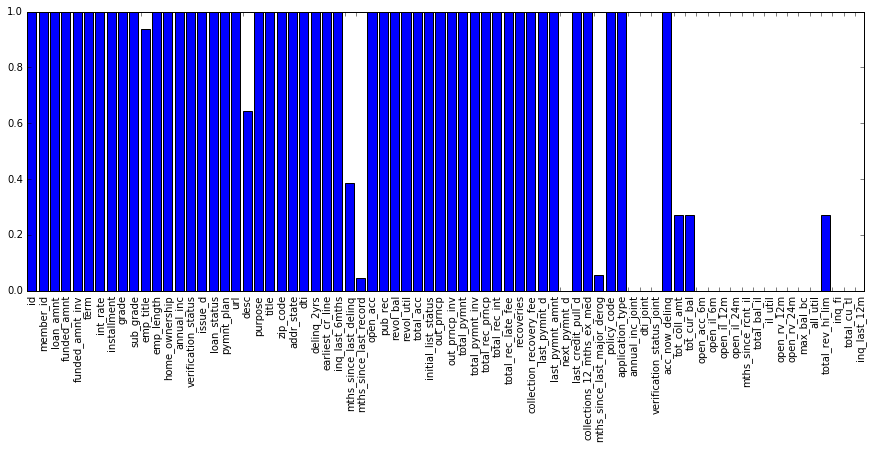

In [6]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
labels = column_name
ax1.xaxis.set_ticks(np.arange(0, 74, 1))
ax1.set_xticklabels(labels, rotation=90, ha='right',rotation_mode='anchor')
ax1.bar(np.arange(74),length)
plt.show()

In [7]:
# Months since last delinquency has missing values if borrower has not had a delinquency, 
# so we replace missings by a large number.

df.mths_since_last_delinq.unique()

df.ix[df.mths_since_last_delinq.isnull(), 'mths_since_last_delinq'] = 9999



In [8]:
# Auxiliary function to replace missings by zero and non-missings by one.

def replace_desc(x):
    if pd.isnull(x):
        return 0
    else:
        return 1


In [9]:
# we replace desc (a string variable with a lot of text) by a variable that takes the value of one if the 
# borrower provided a description for the loan and zero if she/he did not.

df['desc'] = data['desc'].map(replace_desc)
df['emp_title'] = data['emp_title'].map(replace_desc)

In [10]:
# Identifying and dropping the columns that have too many missing values to use.

complete_cols = [column for column in df.columns if len(df[column][df[column].isnull()]) <= len(df[column])/3 ]
df = df[complete_cols]
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,0.00,0.00,0.00,Jan-2015,171.62,Jan-2016,0.0,1.0,INDIVIDUAL,0.0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,0.00,117.08,1.11,Apr-2013,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,0.00,0.00,0.00,Jun-2014,649.91,Jan-2016,0.0,1.0,INDIVIDUAL,0.0
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,16.97,0.00,0.00,Jan-2015,357.48,Jan-2015,0.0,1.0,INDIVIDUAL,0.0
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,0.00,0.00,0.00,Jan-2015,161.03,Sep-2015,0.0,1.0,INDIVIDUAL,0.0


In [11]:
#A second vizualization of the number of missing values
column_name=[]
length=[]
for column in df.columns:
    column_name.append(column)
    longi= 1 - len(df[column][df[column].isnull()]) / float(len(df['id']))
    length.append(longi)

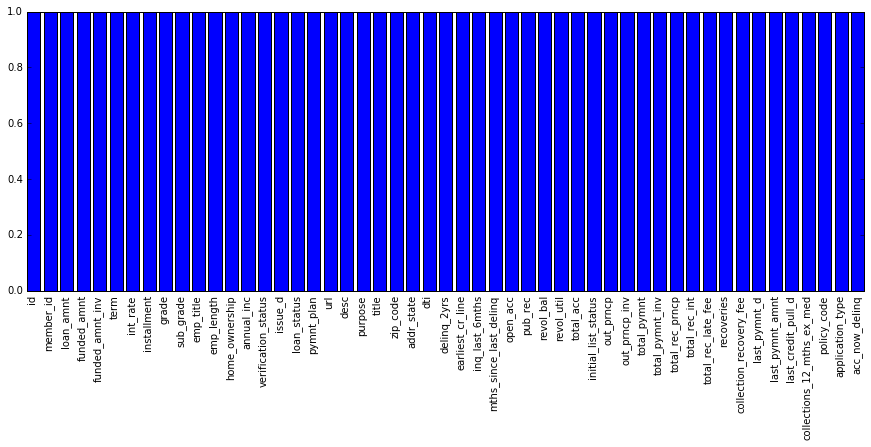

In [12]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
#status.plot.bar(ax=ax1, by='loan_status',width=0.8)
labels = column_name
ax1.xaxis.set_ticks(np.arange(0, 51, 1))
ax1.set_xticklabels(labels, rotation=90, ha='right',rotation_mode='anchor')
ax1.bar(np.arange(51),length)
plt.show()

In [13]:
def replace_missing(x):
    if pd.isnull(x):
        return 'missing'
    else:
        return x

In [14]:
#df['emp_title'] = df['emp_title'].map(replace_missing)

Now we don't have more missing values

### More clean-up

In [15]:
# Dropping variables that we should not use

#Identification variables
df = df.drop('id', axis= 1)
df = df.drop('member_id', axis= 1)

# Non-predictors
df = df.drop('url', axis= 1)
df = df.drop('policy_code', axis= 1)

# Grade variables 
df = df.drop('grade', axis= 1)
df = df.drop('sub_grade', axis= 1)

#Since we only have inactive loans, the ones with outstandign balance are only the ones that defaulted
df = df.drop('out_prncp_inv', axis= 1) 
df = df.drop('out_prncp', axis= 1)

#Ex-post indicators of default
df = df.drop('acc_now_delinq', axis= 1)
df = df.drop('collections_12_mths_ex_med', axis = 1)
df = df.drop('total_pymnt', axis = 1)
df = df.drop('total_pymnt_inv', axis = 1)
df = df.drop('total_rec_prncp', axis = 1)
df = df.drop('total_rec_int', axis = 1)
df = df.drop('total_rec_late_fee', axis = 1)
df = df.drop('recoveries', axis = 1)
df = df.drop('collection_recovery_fee', axis = 1)
df = df.drop('last_pymnt_amnt', axis = 1)
df = df.drop('pymnt_plan', axis = 1)
df = df.drop('revol_util',axis = 1)
df = df.drop('last_pymnt_d', axis= 1)
df = df.drop('last_credit_pull_d', axis= 1)

#Variables that do not vary
df = df.drop('application_type', axis = 1) #all individual

# Too many values in categorical variables 
df = df.drop('zip_code', axis= 1) # We could use this variable but we are using State for geography
#df = df.drop('emp_title', axis= 1) ....same as desc
df = df.drop('title', axis= 1)


In [16]:
# Checking data type of remaining columns
print "Data type:"
print df.dtypes

Data type:
loan_amnt                        float64
funded_amnt                      float64
funded_amnt_inv                  float64
term                              object
int_rate                         float64
installment                      float64
emp_title                          int64
emp_length                        object
home_ownership                    object
annual_inc                       float64
verification_status               object
issue_d                   datetime64[ns]
loan_status                       object
desc                               int64
purpose                           object
addr_state                        object
dti                              float64
delinq_2yrs                      float64
earliest_cr_line                  object
inq_last_6mths                   float64
mths_since_last_delinq           float64
open_acc                         float64
pub_rec                          float64
revol_bal                        float64
total

In [17]:
# getting the number of unique values in every column (float)
aux=df.select_dtypes(include=['float64'])
df_col = aux.columns
print "Number of Unique Values: "
for i in range(len(df_col)):
    print df_col[i] + " - " + str(df[df_col[i]].nunique())

Number of Unique Values: 
loan_amnt - 1106
funded_amnt - 1151
funded_amnt_inv - 8445
int_rate - 406
installment - 23062
annual_inc - 8841
dti - 3493
delinq_2yrs - 16
inq_last_6mths - 9
mths_since_last_delinq - 107
open_acc - 45
pub_rec - 6
revol_bal - 32342
total_acc - 84


In [18]:
# getting the number of unique values in every column (string)
aux=df.select_dtypes(include=['object'])
df_col = aux.columns
print "Number of Unique Values: "
for i in range(len(df_col)):
    print df_col[i] + " - " + str(df[df_col[i]].nunique())

Number of Unique Values: 
term - 2
emp_length - 12
home_ownership - 5
verification_status - 3
loan_status - 3
purpose - 14
addr_state - 50
earliest_cr_line - 564
initial_list_status - 2


#### Crating new features with the data we have to inform algorithm.

In [19]:
# Convert date to date format

df['earliest_cr_line']=df['earliest_cr_line'].apply(lambda x: datetime.strptime(x,'%b-%Y'))


In [20]:
# Create new variable: years since earliest credit line 
# (earliest_cr_line is the date of the borrower's earliest credit line)

df['yrs_since_earliest_cr'] = df['issue_d']-df['earliest_cr_line']
df['yrs_since_earliest_cr'] = df['yrs_since_earliest_cr'].astype('timedelta64[Y]')

df = df.drop('earliest_cr_line', axis= 1)

In [21]:
# Auxiliary variable that we will use later to create the time-test set

df['time_test'] = df['issue_d'] > datetime(2012,9,30)
df = df.drop('issue_d', axis= 1)

In [22]:
df.select_dtypes(include=['object']).head()

,term,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,initial_list_status
0,36 months,10+ years,RENT,Verified,Fully Paid,credit_card,AZ,f
1,60 months,< 1 year,RENT,Source Verified,Charged Off,car,GA,f
2,36 months,10+ years,RENT,Not Verified,Fully Paid,small_business,IL,f
3,36 months,10+ years,RENT,Source Verified,Fully Paid,other,CA,f
5,36 months,3 years,RENT,Source Verified,Fully Paid,wedding,AZ,f


In [23]:
#Creating vriable of interest 

df['default2'] = df['loan_status'].isin(['Charged Off', 'Default'])

df = df.drop('loan_status', axis= 1)

In [24]:
#Encode categorical variables

aux=df.select_dtypes(include=['object'])
categ = aux.columns.tolist()
for feature_name in categ: 
    df = df.join(pd.get_dummies(df[feature_name], prefix = feature_name,drop_first=True))
    df = df.drop(feature_name, axis=1)


In [25]:
df['default']=df['default2']
df=df.drop('default2',axis=1)
df.default = df.default.astype(int)

In [26]:
# Check preliminary correlations

x=df.values
x=x.astype(float)
corr_matrix = np.corrcoef(x.T)

print corr_matrix


[[  1.00000000e+00   9.92281296e-01   9.73704943e-01 ...,   5.20698470e-04
    3.98001627e-02   7.47618864e-02]
 [  9.92281296e-01   1.00000000e+00   9.82494571e-01 ...,   7.70691205e-04
    4.34783663e-02   7.38044614e-02]
 [  9.73704943e-01   9.82494571e-01   1.00000000e+00 ...,   1.68224197e-03
    5.01671755e-02   6.65562427e-02]
 ..., 
 [  5.20698470e-04   7.70691205e-04   1.68224197e-03 ...,   1.00000000e+00
   -3.63674049e-03  -9.14224867e-03]
 [  3.98001627e-02   4.34783663e-02   5.01671755e-02 ...,  -3.63674049e-03
    1.00000000e+00  -5.38013864e-03]
 [  7.47618864e-02   7.38044614e-02   6.65562427e-02 ...,  -9.14224867e-03
   -5.38013864e-03   1.00000000e+00]]


In [27]:
df=df.drop('funded_amnt',axis=1) #almost perfectly correlated with loan amount

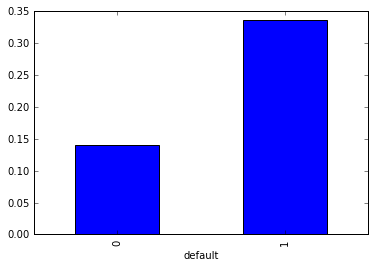

In [28]:
# Check visualization that seems important

df.groupby(['default'])['term_ 60 months'].mean().plot(kind='bar')

### Creating train and test sets

In [29]:
# train and test sets for intertemporal-validation

time_test = df[df['time_test']==1]

time_train = df[df['time_test']==0]


time_test = time_test.drop('time_test', axis= 1)
time_train = time_train.drop('time_test', axis= 1)

In [30]:
x_ttest = time_test.values[:,:-1]
y_ttest = time_test.values[:,-1]

x_ttrain = time_train.values[:,:-1]
y_ttrain = time_train.values[:,-1]

In [31]:
# train and test sets for cross-validation

x_train, x_test, y_train, y_test = train_test_split(x_ttrain , y_ttrain, test_size=0.33, random_state=354)


In [32]:
# Standardization
std_train = x_train.std(axis = 0)
std_test = x_test.std(axis = 0)
std_ttest = x_ttest.std(axis = 0)

# Check for 0 std-dev to avoid dividing by zero
std_train[std_train == 0] = 1
std_test[std_test == 0] = 1
std_ttest[std_ttest == 0] = 1

sx_train = x_train / std_train
sx_test = x_test / std_test
sx_ttest = x_ttest / std_ttest

### Fitting and tunning different models

In [33]:
#KNN Training
#3-fold cross-validation
    
kfold = KFold(len(y_train), 3, random_state=354)

# Keep track of best model
best_score = 0

for k in range(1, 20):
    model = KNN(n_neighbors = k)
    scores = cross_val_score(model, x_train, y_train, cv=kfold, n_jobs=1) 
    
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_n_neighbors = k
print 'Best K: ' + str(best_n_neighbors), '; Score: ' + str(best_score)
print 'Note: no standarization'

Best K: 18 ; Score: 0.841505346875
Note: no standarization


In [34]:
#Unweighted logistic regression Training
#3-fold cross-validation

kfold = KFold(len(y_train), 3, random_state=354)

# Keep track of best model
best_score = 0

for C in range(-7, 7):
    model = LogisticRegression(penalty='l2', C = 10**C)
    scores = cross_val_score(model, sx_train, y_train, cv=kfold, n_jobs=1) 
    
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_C = C
print 'Best C: ' + str(best_C), '; Score: ' + str(best_score)


Best C: 2 ; Score: 0.844460898568


In [35]:
#Unweighted logistic quadratic regression Training
#3-fold cross-validation

kfold = KFold(len(y_train), 3, random_state=354)

# Keep track of best model
best_score = 0

for C in range(-2, 3):
    model = LogisticRegression(penalty='l2', C = 10**C)
    quad_features = preprocessing.PolynomialFeatures(degree = 2)
    x_expanded_train = quad_features.fit_transform(sx_train)
    scores = cross_val_score(model, x_expanded_train, y_train, cv=kfold, n_jobs=1) 

    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_C_poly = C

print 'Best C: ' + str(best_C_poly), '; Score: ' + str(best_score)


Best C: -2 ; Score: 0.838422019009


In [36]:
#Weighted logistic regression Training
#3-fold cross-validation

kfold = KFold(len(y_train), 3, random_state=354)

# Keep track of best model
best_score = 0

for C in range(-7, 7):
    model = LogisticRegression(penalty='l2', C = 10**C, class_weight='balanced')
    scores = cross_val_score(model, sx_train, y_train, cv=kfold, n_jobs=1)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_C_W = C

print 'Best C: ' + str(best_C_W), '; Score: ' + str(best_score)


Best C: 1 ; Score: 0.668466959209


In [37]:
#Decision Tree Training
#3-fold cross-validation

kfold = KFold(len(y_train), 3, random_state=3344)

# To keep track of the best model
best_score = 0

for d in range(1, 30, 2):
    model = DecisionTree(max_depth= d, class_weight='balanced')
    scores = cross_val_score(model, sx_train, y_train, cv=kfold, n_jobs=1) 

    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_depth = d

print 'Best depth: ' + str(best_depth), '; Score: ' + str(best_score)



Best depth: 29 ; Score: 0.739166496021


In [38]:
#Random Forest Training
#3-fold cross-validation

kfold = KFold(len(y_train), 3, random_state=354)

# To keep track of the best model
best_score = 0

for d in range(1, 30, 2):
    model = RandomForest(max_depth=d, class_weight='balanced')
    scores = cross_val_score(model, sx_train, y_train, cv=kfold, n_jobs=1)

    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_depth_rf = d

print 'Best depth: ' + str(best_depth_rf), '; Score: ' + str(best_score)



Best depth: 29 ; Score: 0.83484999245


In [39]:
#SVM Training
#3-fold cross-validation


#kfold = KFold(len(y_train), 3, random_state=354)

# To keep track of the best model
#best_score = 0

# Kernel alternatives
#kernel_list = ['rbf', 'linear', 'poly'] 

#for i in range(0,1):

#    for C in range(-1, 2):
#        model = SVC(C = 10**C, kernel = kernel_list[i], tol=0.1)
#        scores = cross_val_score(model, sx_train, y_train, cv=kfold, n_jobs=1)
#
#        if np.mean(scores) > best_score:
#            best_score = np.mean(scores)
#            best_CSVM = C
#            best_kernel = kernel_list[i]
#    print "done with " + kernel_list[i]
#
#print 'Best C: ' + str(best_CSVM), '; Best Kernel: ' + best_kernel, '; Score: ' + str(best_score)



In [40]:
#Compare models (code from Lecture 19
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                     model.score(x_test[y_test==0], y_test[y_test==0]),
                                                     model.score(x_test[y_test==1], y_test[y_test==1])], 
                                                     index=['overall accuracy', 'accuracy on fully paid', 'accuracy defaulted'])

def compare_models(x_train, sx_train, y_train, x_test, sx_test, y_test):


    #KNN
    start = time.time()
    knn = KNN(n_neighbors = best_n_neighbors)
    knn.fit(x_train, y_train)
    knn_scores = score(knn, x_test, y_test)
    end = time.time()
    knn_time = (end - start)
    print 'KNN works'

    #Unweighted logistic regression
    start = time.time()
    unweighted_logistic = LogisticRegression(penalty='l2', C = 10**best_C)
    unweighted_logistic.fit(sx_train, y_train)
    unweighted_log_scores = score(unweighted_logistic, sx_test, y_test)
    end = time.time()
    unweighted_log_time = (end - start)
    print 'ulog works'

    #Unweighted logistic quadratic regression
    start = time.time()
    unweighted_logistic_poly = LogisticRegression(penalty='l2', C = 10**best_C_poly)
    #Expand our predictor array with quadratic terms
    quad_features = preprocessing.PolynomialFeatures(degree = 2)
    x_expanded_train = quad_features.fit_transform(sx_train)
    x_expanded_test = quad_features.fit_transform(sx_test)
    unweighted_logistic_poly.fit(x_expanded_train, y_train)
    unweighted_log_poly_scores = score(unweighted_logistic_poly, x_expanded_test, y_test)
    end = time.time()
    unweighted_log_poly_time = (end - start)
    print 'log poly works'

    #Weighted logistic regression
    start = time.time()
    weighted_logistic = LogisticRegression(C = 10**best_C_W, class_weight='balanced')
    weighted_logistic.fit(sx_train, y_train)
    weighted_log_scores = score(weighted_logistic, sx_test, y_test)
    end = time.time()
    weighted_log_time = (end - start)
    print 'wlog works'

    #LDA
    start = time.time()
    lda = LDA(priors = None)
    lda.fit(sx_train, y_train)
    lda_scores = score(lda, sx_test, y_test)
    end = time.time()
    lda_time = (end - start)
    print 'lda works'

    #QDA
    start = time.time()
    qda = QDA(priors = None)
    qda.fit(sx_train, y_train)
    qda_scores = score(qda, sx_test, y_test)
    end = time.time()
    qda_time = (end - start)
    print 'qda works'

    #Decision Tree
    start = time.time()
    tree = DecisionTree(max_depth= best_depth, class_weight='balanced')
    tree.fit(sx_train, y_train)
    tree_scores = score(tree, sx_test, y_test)
    end = time.time()
    tree_time = (end - start)
    print 'dt works'

    #Random Forest
    start = time.time()
    rf = RandomForest(max_depth=best_depth_rf, class_weight='balanced')
    rf.fit(sx_train, y_train)
    rf_scores = score(rf, sx_test, y_test)
    end = time.time()
    rf_time = (end - start)
    print 'rf works'

    #SVM
    #start = time.time()
    #svm = SVC(C=10**best_CSVM, kernel = best_kernel)
    #svm.fit(sx_train, y_train)
    #svm_scores = score(svm, sx_test, y_test)
    #end = time.time()
    #svm_time = (end - start)


    #Score Dataframe
    score_df = pd.DataFrame({'knn': knn_scores,
                             'unweighted logistic': unweighted_log_scores,
                             'unweighted quad. logistic': unweighted_log_poly_scores,
                             'weighted logistic': weighted_log_scores,
                             'lda': lda_scores,
                             'qda': qda_scores,
                             'tree': tree_scores,
                             'rf': rf_scores,
                             #'svm': svm_scores
                              })


    time_df = pd.DataFrame({'knn': knn_time,
                            'unweighted logistic': unweighted_log_time,
                            'unweighted quad. logistic': unweighted_log_time,
                            'weighted logistic': unweighted_log_poly_time,
                            'lda': lda_time,
                            'qda': qda_time,
                            'tree': tree_time,
                            'rf': rf_time, 
                            #'svm': svm_time
                             }, 
                             index=['time elapsed'])

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    f1, t1, thresholds = metrics.roc_curve(y_test, knn.predict_proba(x_test)[:,1])
    f2, t2, thresholds = metrics.roc_curve(y_test, unweighted_logistic.predict_proba(sx_test)[:,1])
    f3, t3, thresholds = metrics.roc_curve(y_test, unweighted_logistic_poly.predict_proba(x_expanded_test)[:,1])
    f4, t4, thresholds = metrics.roc_curve(y_test, weighted_logistic.predict_proba(sx_test)[:,1])
    f5, t5, thresholds = metrics.roc_curve(y_test, lda.predict_proba(sx_test)[:,1])
    f6, t6, thresholds = metrics.roc_curve(y_test, qda.predict_proba(sx_test)[:,1])
    f7, t7, thresholds = metrics.roc_curve(y_test, tree.predict_proba(sx_test)[:,1])
    f8, t8, thresholds = metrics.roc_curve(y_test, rf.predict_proba(sx_test)[:,1])

    plot1=ax.plot(f8,t8,color='green',label='random forest')
    plot2=ax.plot(f7,t7,'k--',color='yellow',label='decision tree')
    plot3=ax.plot(f6,t6,color='red',label='qda')
    plot4=ax.plot(f5,t5,color='orange',label='lda')
    plot6=ax.plot(f3,t3,color='blue',label='unweighted quadratic logistic')
    plot7=ax.plot(f2,t2,color='gray',label='unweighted logistic')
    plot8=ax.plot(f1,t1,color='purple',label='knn')
    plot5=ax.plot(f4,t4,color='cyan',label='weighted logistic')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    
    score_df = score_df.append(time_df)

    return score_df

Results for observed data (training-test set)
KNN works
ulog works
log poly works
wlog works


/Users/Pranav/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Pranav/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


lda works
qda works
dt works
rf works


,knn,lda,qda,rf,tree,unweighted logistic,unweighted quad. logistic,weighted logistic
overall accuracy,0.842046,0.841615,0.397151,0.832981,0.736758,0.843212,0.841830,0.670710
accuracy on fully paid,0.999333,0.985026,0.345777,0.976309,0.819394,0.992257,0.987642,0.678324
accuracy defaulted,0.004913,0.078330,0.670579,0.070142,0.296943,0.049945,0.065775,0.630186
time elapsed,8.849504,0.672352,0.695275,1.128315,1.220030,1.065371,1.065371,42.427398


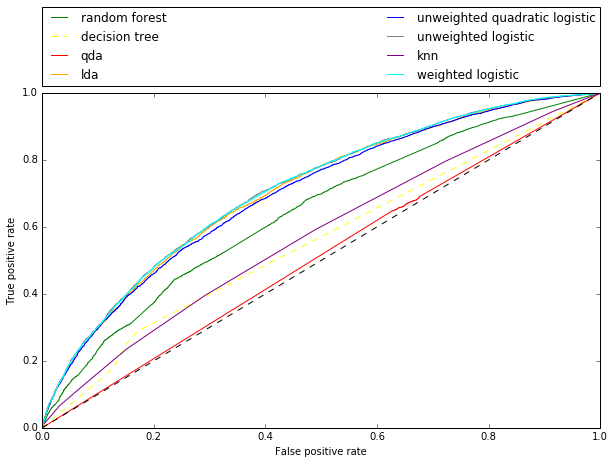

In [41]:
print "Results for observed data (training-test set)"

results_observed = compare_models(x_train, sx_train, y_train, x_test, sx_test, y_test)

results_observed

### Feature Importance 

In [42]:
# Check feature importance using a decision tree
dt = DecisionTree(class_weight='balanced')
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)

x_pandas = time_train.drop('default',axis=1)

# Analyze feature importance
feature_imps = pd.DataFrame({'feature': x_pandas.columns, 'importance': dt.feature_importances_})
feature_imps.sort_values(by='importance', ascending=False, inplace=True)
print("Top 10 important features:")
print(feature_imps[:10])

Top 10 important features:
                   feature  importance
2                 int_rate    0.135419
7                      dti    0.091437
13               revol_bal    0.083505
5               annual_inc    0.079818
14               total_acc    0.056066
3              installment    0.053116
15   yrs_since_earliest_cr    0.051500
1          funded_amnt_inv    0.042844
11                open_acc    0.041649
10  mths_since_last_delinq    0.029435


Results for future data (time-test set)
KNN works
ulog works
log poly works
wlog works
lda works
qda works
dt works
rf works


,knn,lda,qda,rf,tree,unweighted logistic,unweighted quad. logistic,weighted logistic
overall accuracy,0.844950,0.840514,0.332049,0.828955,0.703036,0.842790,0.839405,0.614886
accuracy on fully paid,0.997724,0.968959,0.256260,0.957577,0.770711,0.975926,0.969580,0.606884
accuracy defaulted,0.003798,0.133308,0.749335,0.120775,0.330422,0.109761,0.122674,0.658944
time elapsed,7.126392,0.547911,0.545911,1.191704,1.357361,0.854913,0.854913,30.867841


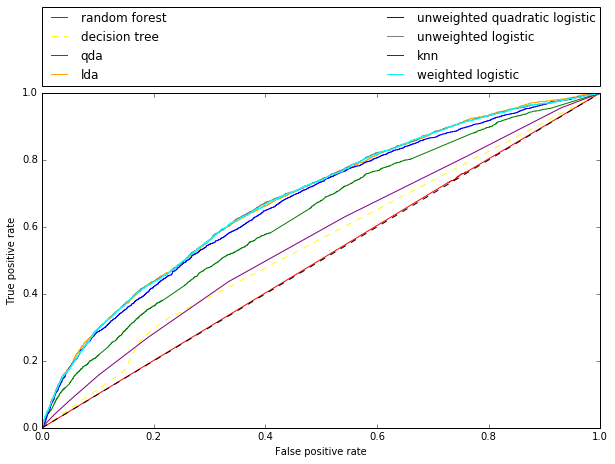

In [43]:
print "Results for future data (time-test set)"

results_future = compare_models(x_train, sx_train, y_train, x_ttest, sx_ttest, y_ttest)

results_future

In [44]:
categ


['term',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status']

## Estimated probabilities of default and Proposed Scoring


In [45]:
# Estimating probabilities of default 

#Model: Weighted logistic regression
weighted_logistic = LogisticRegression(C = 10**best_C_W, class_weight='balanced')
weighted_logistic.fit(sx_train, y_train)

#Estimating probabilities 
predicted_prob_test = weighted_logistic.predict_proba(sx_test)
predicted_prob_ttest = weighted_logistic.predict_proba(sx_ttest)

In [46]:
predicted_prob_ttest

array([[ 0.38474964,  0.61525036],
       [ 0.44766476,  0.55233524],
       [ 0.24103647,  0.75896353],
       ..., 
       [ 0.17693473,  0.82306527],
       [ 0.58147803,  0.41852197],
       [ 0.50990363,  0.49009637]])

In [47]:
# For comparison with LC grades and actual default grades:

df_grade = data[data['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

df_grade=df_grade[df_grade['issue_d']<=datetime(2012,12,31)] 

time_test_grade = df_grade.loc[time_test.index] 

time_test_grade['pred_prob_default'] = predicted_prob_ttest[:,1:].astype(float)

In [48]:
#Proposed socore: score from 1 to 10 with 1 being the worst loan quality and 10 being the best.

time_test_grade['score'] = time_test_grade['pred_prob_default'].round(1)*10

time_test_grade['score'] = 10 - time_test_grade['score']

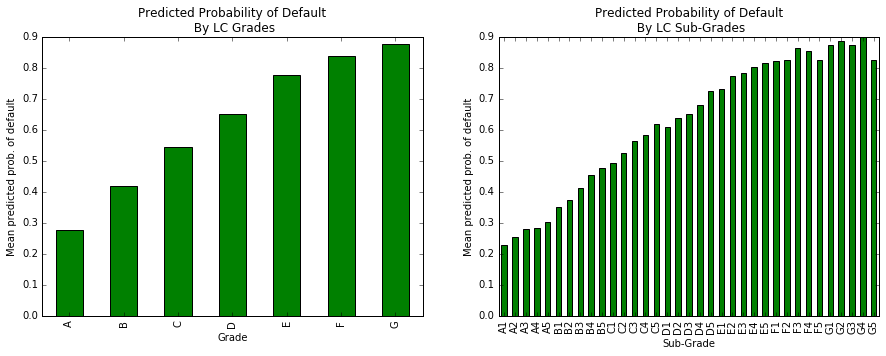

In [50]:
# Compatring our predicted probabilities to LC grades: highly correlated.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

time_test_grade.groupby(['grade'])['pred_prob_default'].mean().plot(kind='bar', ax=ax1, color = plt.rcParams['axes.color_cycle'][1])
ax1.set_xlabel('Grade')
ax1.set_ylabel('Mean predicted prob. of default')
ax1.set_title('Predicted Probability of Default' '\n By LC Grades')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

time_test_grade.groupby(['sub_grade'])['pred_prob_default'].mean().plot(kind='bar', ax=ax2, color = plt.rcParams['axes.color_cycle'][1])
ax2.set_xlabel('Sub-Grade')
ax2.set_ylabel('Mean predicted prob. of default')
ax2.set_title('Predicted Probability of Default' '\n By LC Sub-Grades')
ax2.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_color('k')
    
plt.show()

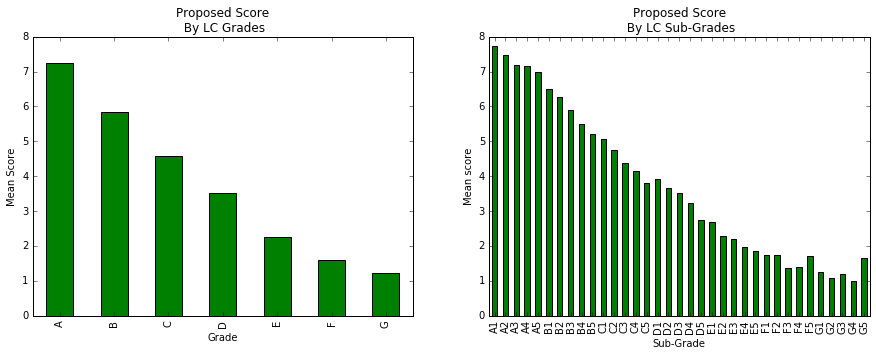

In [51]:
# Compatring our score to LC grades: highly correlated.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

time_test_grade.groupby(['grade'])['score'].mean().plot(kind='bar', ax=ax1, color = plt.rcParams['axes.color_cycle'][1])
ax1.set_xlabel('Grade')
ax1.set_ylabel('Mean Score')
ax1.set_title('Proposed Score' '\n By LC Grades')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')

time_test_grade.groupby(['sub_grade'])['score'].mean().plot(kind='bar', ax=ax2, color = plt.rcParams['axes.color_cycle'][1])
ax2.set_xlabel('Sub-Grade')
ax2.set_ylabel('Mean score')
ax2.set_title('Proposed Score' '\n By LC Sub-Grades')
ax2.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_color('k')
    
plt.show()

In [52]:
time_test_grade['default'] = time_test_grade['loan_status'].isin(['Charged Off', 'Default'])



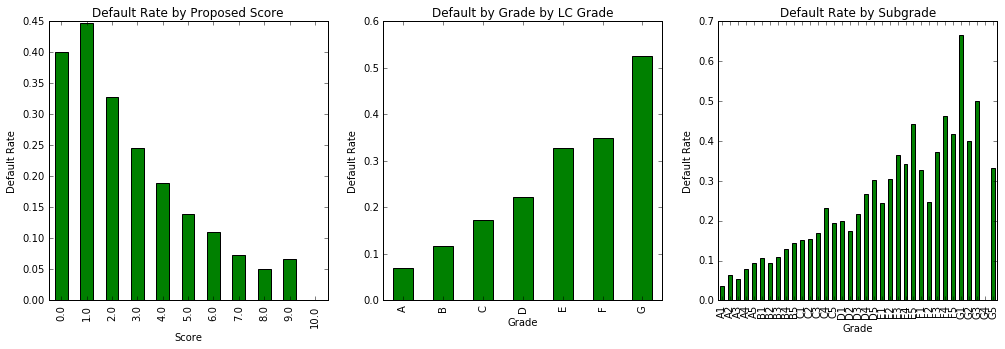

In [53]:
# Comparing the three scoring methods

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

time_test_grade.groupby(['score'])['default'].mean().plot(kind='bar', ax=ax1, color = plt.rcParams['axes.color_cycle'][1])
ax1.set_xlabel('Score')
ax1.set_ylabel('Default Rate')
ax1.set_title('Default Rate by Proposed Score')
ax1.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_color('k')
    
time_test_grade.groupby(['grade'])['default'].mean().plot(kind='bar', ax=ax2, color = plt.rcParams['axes.color_cycle'][1])
ax2.set_xlabel('Grade')
ax2.set_ylabel('Default Rate')
ax2.set_title('Default by Grade by LC Grade')
ax2.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_color('k')
    
time_test_grade.groupby(['sub_grade'])['default'].mean().plot(kind='bar', ax=ax3, color = plt.rcParams['axes.color_cycle'][1])
ax3.set_xlabel('Grade')
ax3.set_ylabel('Default Rate')
ax3.set_title('Default Rate by Subgrade')
ax3.set_axis_bgcolor('white')
for spine in ['left','right','top','bottom']:
    ax3.spines[spine].set_color('k')
    